In [1]:
library('tidymodels')
library('tidyverse')
library('palmerpenguins')

theme_set(theme_gray(base_size = 16))

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.2.1
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.1.0
✔ purrr        1.0.2     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖

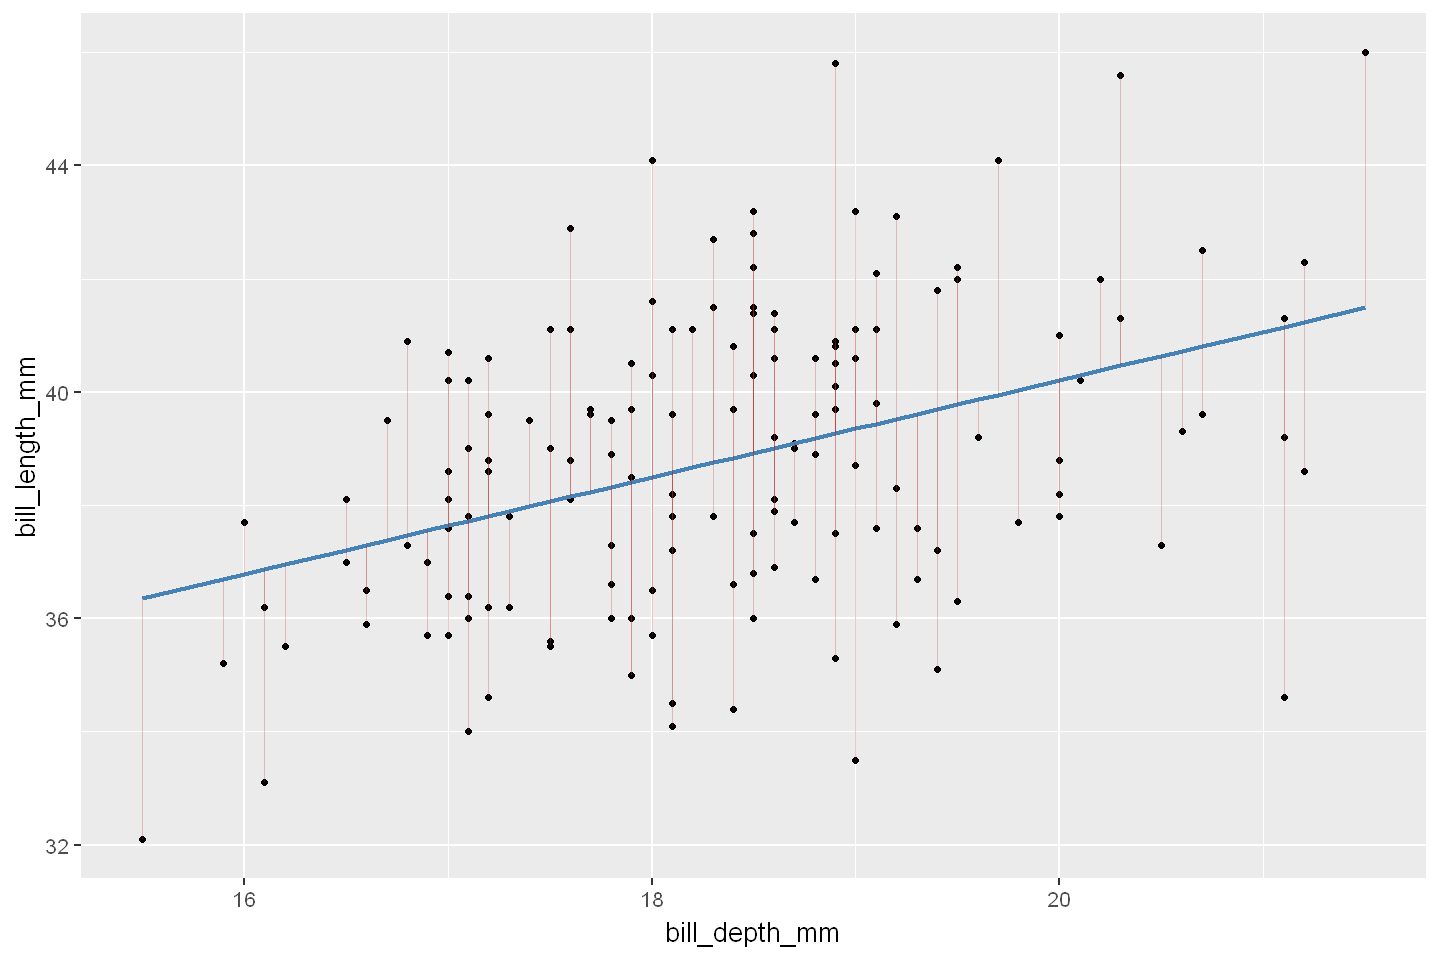

In [13]:
# Adelie data from Week 2 lecture

adelie_data = penguins |>
    filter(species == 'Adelie') |>
    select(bill_length_mm, bill_depth_mm, species) |>
    drop_na()

mod = linear_reg() |> set_engine("lm")

mod_fit = mod |> fit(bill_length_mm ~ bill_depth_mm, data = adelie_data)

adelie_data2 = augment(mod_fit, adelie_data)

options(repr.plot.height = 8, repr.plot.width = 12)

ggplot(adelie_data2) +
  geom_point(aes(x = bill_depth_mm, y = bill_length_mm)) +
  geom_line(aes(x = bill_depth_mm, y = .pred), color = 'steelblue', linewidth = 1.2) +
  geom_segment(aes(x = bill_depth_mm, xend = bill_depth_mm, y = .pred, yend = bill_length_mm),
               color = 'firebrick',
               alpha = 0.25)

## Bootstrap resample and model

In [3]:
boots = bootstraps(adelie_data, times = 1000)

boots |> glimpse()

Rows: 1,000
Columns: 2
$ splits <list> [<boot_split[151 x 56 x 151 x 3]>], [<boot_split[151 x 55 x 15…
$ id     <chr> "Bootstrap0001", "Bootstrap0002", "Bootstrap0003", "Bootstrap00…


In [4]:
fit_mod_on_bootstrap = function(split) {
    mod = linear_reg() |> set_engine("lm")
    mod_fit = mod |> fit(bill_length_mm ~ bill_depth_mm, data = as.data.frame(split))
    return(mod_fit)
}

In [5]:
fit_mod_on_bootstrap(adelie_data) |> tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),23.0680794,3.0342298,7.602615,3.007505e-12
bill_depth_mm,0.8570263,0.1650259,5.193285,6.674141e-07


In [5]:
boot_models = boots |> 
  mutate(model = map(splits, fit_mod_on_bootstrap),
         coef_info = map(model, tidy))

In [6]:
boot_models |> glimpse()

Rows: 1,000
Columns: 4
$ splits    <list> [<boot_split[151 x 56 x 151 x 3]>], [<boot_split[151 x 55 x…
$ id        <chr> "Bootstrap0001", "Bootstrap0002", "Bootstrap0003", "Bootstra…
$ model     <list> [NULL, ~NULL, ~NULL, regression, FALSE, stats, formula, for…
$ coef_info <list> [<tbl_df[2 x 5]>], [<tbl_df[2 x 5]>], [<tbl_df[2 x 5]>], [<…


In [7]:
boot_models |> pull(coef_info) |> head(1)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),24.9758400,3.0818759,8.104103,1.778030e-13
bill_depth_mm,0.7464232,0.1686056,4.427038,1.836646e-05


In [8]:
boot_coefs = 
  boot_models |> 
  unnest(coef_info) |>
  select(-splits, -model)

boot_coefs |> head()

id,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Bootstrap0001,(Intercept),24.9758400,3.0818759,8.104103,1.778030e-13
Bootstrap0001,bill_depth_mm,0.7464232,0.1686056,4.427038,1.836646e-05
Bootstrap0002,(Intercept),22.7620668,2.9875924,7.618866,2.747183e-12
Bootstrap0002,bill_depth_mm,0.8729209,0.1628271,5.361028,3.088239e-07
Bootstrap0003,(Intercept),26.5720034,2.9196544,9.101078,5.374912e-16
Bootstrap0003,bill_depth_mm,0.6772573,0.1596040,4.243361,3.853680e-05


In [9]:
percentile_intervals = int_pctl(boot_models, coef_info)
percentile_intervals

term,.lower,.estimate,.upper,.alpha,.method
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),16.8059854,22.9281601,29.213626,0.05,percentile
bill_depth_mm,0.5199754,0.8650785,1.204156,0.05,percentile


## Visualize a subsample of models

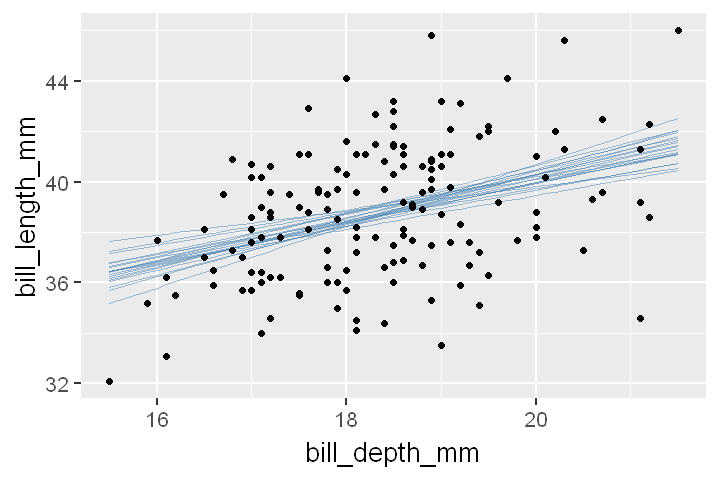

In [10]:
boot_aug = boot_models |> 
    sample_n(20) |> 
    mutate(augmented = map(model, augment, new_data = adelie_data)) |> 
    unnest(augmented) |>
    select(-model, -splits, -coef_info)

ggplot(boot_aug, aes(x = bill_depth_mm, y = bill_length_mm)) +
  geom_line(aes(y = .pred, group = id), alpha = .5, col = "steelblue") +
  geom_point()

## Model coefficient confidence intervals

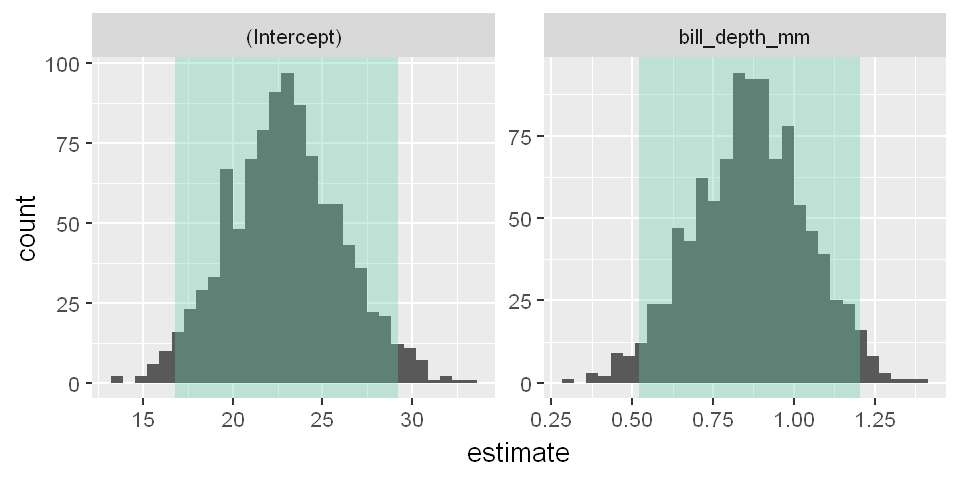

In [12]:
options(repr.plot.height = 4, repr.plot.width = 8)

ggplot(boot_coefs) +
    geom_histogram(bins = 30, data = boot_coefs, mapping = aes(x = estimate)) +
    facet_wrap( ~ term, scales = "free") +
    geom_rect(data = percentile_intervals, 
              mapping = aes(xmin = .lower, xmax = .upper, ymin = -Inf, ymax = Inf),
              alpha = 0.35, fill = 'MediumAquaMarine')